## Download data

In [1]:
!git clone "https://github.com/xhxuciedu/CS284A.git"

Cloning into 'CS284A'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 13119 (delta 33), reused 2 (delta 0), pack-reused 13070
Receiving objects: 100% (13119/13119), 203.96 MiB | 33.30 MiB/s, done.
Resolving deltas: 100% (51/51), done.
Checking out files: 100% (13028/13028), done.


In [2]:
BASE_DIR = "/content/CS284A/wbc-classification/"

In [3]:
!ls

CS284A	sample_data


# Classifying White Blood Cells

### Introduction

An important problem in blood diagnostics is classifying different types of blood cells. In this notebook, we will attempt to train a classifier to predict the type of a blood cell given a dyed picture of it.

### Data

We have 352 pictures of dyed white blood cells along with labels of what type of blood cell they are. Below is an example of each of the types of blood cells in our dataset.

##### Basophil
<img src="https://github.com/xhxuciedu/CS284A/blob/master/wbc-classification/notebooks/Basophil.jpg?raw=1" width=400>

#### Eosinophil
<img src="https://github.com/xhxuciedu/CS284A/blob/master/wbc-classification/notebooks/Eosinophil.jpg?raw=1" width=400>

#### Lymphocyte
<img src="https://github.com/xhxuciedu/CS284A/blob/master/wbc-classification/notebooks/Lymphocyte.jpg?raw=1" width=400>

#### Monocyte
<img src="https://github.com/xhxuciedu/CS284A/blob/master/wbc-classification/notebooks/Monocyte.jpg?raw=1" width=400>

#### Neutrophil
<img src="https://github.com/xhxuciedu/CS284A/blob/master/wbc-classification/notebooks/Neutrophil.jpg?raw=1" width=400>

### Methodology

We use a simple LeNet architecture trained on 281 training samples with image augmentation. Our augmentation techniques include rotations, shifts, and zooms.

We validate our results against 71 samples.


# Code

In [4]:
import numpy as np
import matplotlib.pyplot as plt
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Activation, Flatten
# from keras.layers import Conv2D, MaxPooling2D, Lambda
# from keras.layers import Dense
# from keras.utils import np_utils
# from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import cv2
import scipy
import os

In [5]:
epochs = 20
batch_size = 32

## get data 

In [6]:
from skimage.transform import resize

In [7]:
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []

    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL', 'EOSINOPHIL']:
                label = 'POLYNUCLEAR'
            else:
                label = 'MONONUCLEAR'
            for image_filename in os.listdir(folder + wbc_type):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    # Downsample the image to 120, 160, 3
                    #img_file = scipy.misc.imresize(arr=img_file, size=(120, 160, 3))
                    img_file = resize(img_file, (120, 160, 3), order=1)
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [8]:
# read data
X_train, y_train = get_data(BASE_DIR + 'images/TRAIN/')
X_test, y_test = get_data(BASE_DIR + 'images/TEST_SIMPLE/')

encoder = LabelEncoder()  # convert labels to 0 to n-1
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

In [9]:
y_train.shape, X_train.shape

((9957,), (9957, 120, 160, 3))

## pytorch model

In [10]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

### Check GPU availability

In [45]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### Hyper parameters

In [12]:
# Hyper parameters
num_classes = 2
batch_size = 32

### train and test dataloader
* transpose input numpy.  input shape: 120x160x3 -> 3x120x160
* Create dataset (torch.tensor type)
* Create dataloder

In [13]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [14]:
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train.transpose(0,3,1,2)).float(), torch.from_numpy(y_train))
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_test.transpose(0,3,1,2)).float(), torch.from_numpy(y_test))

In [15]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,                                           
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=len(test_dataset), 
                                          shuffle=False)

In [16]:
len(test_dataset)

71

### Check dataloader

In [17]:
images, labels = next(iter(train_loader))

In [18]:
print(images.shape, labels.shape)

torch.Size([32, 3, 120, 160]) torch.Size([32])


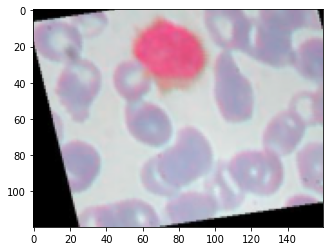

In [19]:
plt.imshow(images[0,:,:,:].cpu().permute(1,2,0))

### Model

In [91]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(15*20*64, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)  # 3x120x160 -> 16x60x80
        out = self.layer2(out) # 16x60x80 -> 32x30x40
        out = self.layer3(out) # 32x30x40 -> 32x15x20
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model = ConvNet(num_classes).to(device)

In [92]:
print(model)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=19200, out_features=2, bias=True)
)


### test the model; run the model

In [88]:
tmp = model(images.to(device))

In [89]:
tmp.shape, images.shape

(torch.Size([5, 2]), torch.Size([5, 3, 120, 160]))

In [90]:
tmp

tensor([[-0.0052,  0.0032],
        [-0.0052,  0.0032],
        [-0.0052,  0.0032],
        [-0.0052,  0.0032],
        [-0.0052,  0.0032]], device='cuda:0', grad_fn=<AddmmBackward>)

### training

In [93]:
learning_rate = 0.001
num_epochs = 10

In [94]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [95]:
# Train the model
model.train()
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))


Epoch [1/10], Step [100/312], Loss: 0.6903
Epoch [1/10], Step [200/312], Loss: 0.6944
Epoch [1/10], Step [300/312], Loss: 0.6451
Epoch [2/10], Step [100/312], Loss: 0.4125
Epoch [2/10], Step [200/312], Loss: 0.0935
Epoch [2/10], Step [300/312], Loss: 0.0132
Epoch [3/10], Step [100/312], Loss: 0.0101
Epoch [3/10], Step [200/312], Loss: 0.0388
Epoch [3/10], Step [300/312], Loss: 0.0069
Epoch [4/10], Step [100/312], Loss: 0.0331
Epoch [4/10], Step [200/312], Loss: 0.0086
Epoch [4/10], Step [300/312], Loss: 0.0664
Epoch [5/10], Step [100/312], Loss: 0.0008
Epoch [5/10], Step [200/312], Loss: 0.0037
Epoch [5/10], Step [300/312], Loss: 0.0164
Epoch [6/10], Step [100/312], Loss: 0.0014
Epoch [6/10], Step [200/312], Loss: 0.0063
Epoch [6/10], Step [300/312], Loss: 0.0161
Epoch [7/10], Step [100/312], Loss: 0.0701
Epoch [7/10], Step [200/312], Loss: 0.0094
Epoch [7/10], Step [300/312], Loss: 0.0004
Epoch [8/10], Step [100/312], Loss: 0.0102
Epoch [8/10], Step [200/312], Loss: 0.0014
Epoch [8/10

In [98]:
outputs, labels

(tensor([[-12.9933,  12.9542],
         [-32.0847,  32.0008],
         [ -7.6282,   7.7113],
         [ 15.3384, -15.3075],
         [-21.4810,  21.5824]], device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([1, 1, 1, 0, 1], device='cuda:0'))

In [99]:
# Training accuracy
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the {} train images: {:.3f} %'.format(total,100 * correct / total))

Test Accuracy of the model on the 9957 train images: 100.000 %


### Testing

In [100]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the {} test images: {:.3f} %'.format(total,100 * correct / total))

Test Accuracy of the model on the 71 test images: 97.183 %


# Accuracy

In [101]:
y_pred = predicted.cpu().numpy()

In [102]:
from sklearn.metrics import accuracy_score

print('Predicting on test data')
print(accuracy_score(y_test, y_pred))

Predicting on test data
0.971830985915493


# Confusion Matrix

In [103]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

[[ 8  2]
 [ 0 61]]


# Images Misclassified

In [104]:
false_positive_mononuclear = np.intersect1d(np.where(y_pred == 1), np.where(y_test == 0))

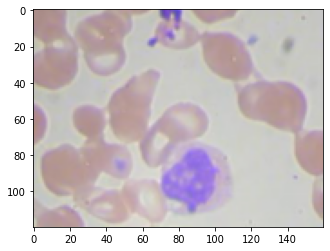

In [105]:
img = X_test[false_positive_mononuclear[0]].astype('float32')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Mononuclear Cells Classified Correctly

In [106]:
true_positive_mononuclear = np.intersect1d(np.where(y_pred == 1), np.where(y_test == 1))

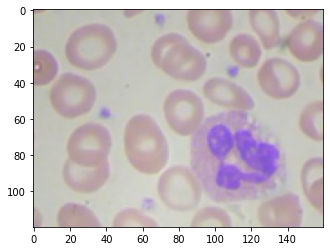

In [107]:
img = X_test[true_positive_mononuclear[0]].astype('float32')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Polynuclear Cells Classified Correctly

In [108]:
true_positive_polynuclear = np.intersect1d(np.where(y_pred == 0), np.where(y_test == 0))

In [109]:
#img = X_test[true_positive_polynuclear[0]].astype('float32')
#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))